<a href="https://colab.research.google.com/github/enriqueasegura/Quantum-X/blob/master/H2_Molecule_Simulation_with_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
from sympy import Symbol
import matplotlib

!pip install qiskit

from qiskit import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#Matrix Decomposition 

$\begin{equation*}
H_{total} = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 1& 0 \\
0 & 1 & -1& 0 \\\
0 & 0 & 0 & 0 
\end{pmatrix}
\end{equation*}
$

using circuits.

Through decomposition we find:

\begin{eqnarray}
H_{total} &=& H_1 + H_2 + H_3 + H_4 \\
H_{total} &=& \frac{-1}{2} ( I_1 \otimes I_2 ) +
      \frac{1}{2}  (X_1 \otimes X_2 ) +
      \frac{1}{2}  (Y_1 \otimes Y_2) +
      \frac{1}{2} (Z_1 \otimes Z_2)
\end{eqnarray}

This represents the decomposition of the hamiltonian of interest for this task. Each tensor product - minus the first term - will be implemented as a quantum circuit below. 

Sidenote: 

\begin{eqnarray}
H_2 + H_3 &=&\frac{1}{2} \Bigg\{ (X_1 \otimes X_2 ) +  (Y_1 \otimes Y_2) \Bigg\}
\end{eqnarray}

This expression commutes. Thus, we can compress this into a single circuit.

In [0]:
#borrowed from Michael H. Goerz

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    #modified from his original xrange because it was not working
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

In [3]:
h_initial = np.array([[0,0,0,0], 
                      [0, -1, 1, 0], 
                      [0,1,-1,0], 
                      [0,0,0,0]])

h_decomposed = decompose(h_initial)

-0.5	*	( I \otimes I )
0.5	*	( sigma_x \otimes sigma_x )
0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


#Papers I am following: 

1. https://arxiv.org/pdf/1909.05074.pdf
2. https://arxiv.org/pdf/1108.4318.pdf
3. https://quantumcomputing.stackexchange.com/questions/8583/how-to-factor-ising-yy-coupling-gate-into-product-of-basic-gates
4.

In [0]:
def ansatz_h2(layer_1_theta_0, layer_1_theta_1, layer_2_theta_0, layer_2_theta_1):
  #layer_num_theta_qubit_number 

  qc = QuantumCircuit()

  #get the quantum and classical registrars
  qr = QuantumRegister(2)
  cr = ClassicalRegister(2)

  #add the registrar
  qc.add_register(qr)
  qc.add_register(cr)

  qc.ry(theta=2*layer_1_theta_0 , qubit=qr[0])
  qc.ry(theta=2*layer_1_theta_1 , qubit=qr[1])

  qc.cnot( qr[0], qr[1] )

  qc.ry(theta=2*layer_2_theta_0, qubit=qr[0])
  qc.ry(theta=2*layer_2_theta_1 , qubit=qr[1])

  qc.measure(qr[0],cr[0])
  qc.measure(qr[1],cr[0])

  return qc


Parameters for Layers 1 and 2: 0.5169897110381668 3.818739952922285 4.297966776262426 6.213576597301163


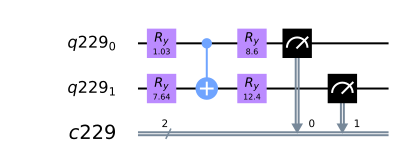

In [55]:
#example of the circuit we want to make to simulate a hydrogen molecule
"""
qc = QuantumCircuit()

#quantum register name qreg
qr = QuantumRegister(2,'qreg')

qc.add_register( qr )
cr = ClassicalRegister(2,'creg')
qc.add_register(cr)

qc.qregs
"""
#first layer 
y1_theta_0 = np.random.uniform(0,2*np.pi)
y1_theta_1 = np.random.uniform(0,2*np.pi)
#second layer
y2_theta_0 = np.random.uniform(0,2*np.pi)
y2_theta_1 = np.random.uniform(0,2*np.pi)


print('Parameters for Layers 1 and 2:', y1_theta_0, y1_theta_1, y2_theta_0, y2_theta_1)

test_ansatz_h2 = ansatz_h2(y1_theta_0, y1_theta_1, y2_theta_0, y2_theta_1)

test_ansatz_h2.draw(output='mpl')

In [0]:
def ansatz_search(layer_1_theta_0, layer_1_theta_1, layer_2_theta_0, layer_2_theta_1, num_shots):
  
  energy_arr =[]
  loss_arr = []
  
  layer1_theta_0_arr = []
  layer1_theta_1_arr = []
  
  layer2_theta_0_arr = []
  layer2_theta_1_arr = []

  status = 'not done'

  count = 0
  learning_rate = 0.01
  

  while status != 'done' or count > 2000:

    #keep values on gates
    
    layer1_theta_0_arr.append(layer_1_theta_0)
    layer1_theta_1_arr.append(layer_1_theta_1)
    layer2_theta_0_arr.append(layer_2_theta_0)
    layer2_theta_1_arr.append(layer_2_theta_1)

    #execute circuit
    curr_circuit = ansatz_h2(layer_1_theta_0, layer_1_theta_1, layer_2_theta_0, layer_2_theta_1)
    curr_emulator = Aer.get_backend('qasm_simulator')
    #simulate the circuit
    curr_job = execute(curr_circuit, emulator, shots=num_shots, memory=True)
    

    #get the counts
    curr_counts = curr_job.result().get_counts()
    plot_histogram(curr_counts)

    curr_expected_value = np.divide(curr_counts['00'] -  curr_counts['01'] , num_shots)

    curr_loss = 1 - np.square(curr_expected_value)

    loss_arr.append(curr_loss)

    energy_arr.append(curr_expected_value)

    current_gradient_value = 2*curr_expected_value

    current_gradient_squared = np.square(current_gradient_value)

    print('count: ', count, 'current expected value:', curr_expected_value, 'current loss:', curr_loss)
    
    if np.absolute(curr_loss) < 1e-2:
    #elif np.absolute(target_difference) < 1e-3:
      status = 'done'
      print('Done! Final Weights: ',layer1_theta_0_arr[-1], layer1_theta_1_arr[-1], layer2_theta_0_arr[-1],layer2_theta_1_arr[-1], 'Final Energy:', energy_arr[-1])
      break
    
    else:
      
      layer_1_theta_0 -= learning_rate * (curr_loss / current_gradient_squared) * current_gradient_value
      layer_1_theta_1 -= learning_rate * (curr_loss / current_gradient_squared) * current_gradient_value
      layer_2_theta_0 -= learning_rate * (curr_loss / current_gradient_squared) * current_gradient_value
      layer_2_theta_1 -= learning_rate * (curr_loss / current_gradient_squared) * current_gradient_value

      count+=1 
  
  return(layer1_theta_0_arr, layer1_theta_1_arr, layer2_theta_0_arr, layer2_theta_1_arr, loss_arr,  energy_arr)



In [0]:
shot_num = 1000
#first layer 
y1_theta_0 = np.random.uniform(0,2*np.pi)
y1_theta_1 = np.random.uniform(0,2*np.pi)
#second layer
y2_theta_0 = np.random.uniform(0,2*np.pi)
y2_theta_1 = np.random.uniform(0,2*np.pi)

In [105]:
print('Parameters for Layers 1 and 2:', y1_theta_0, y1_theta_1, y2_theta_0, y2_theta_1)
test_search =  ansatz_search(y1_theta_0, y1_theta_1, y2_theta_0, y2_theta_1, shot_num)

Parameters for Layers 1 and 2: 5.891531500227738 4.937627862204331 3.646871275071671 4.962662775959007
count:  0 current expected value: 0.386 current loss: 0.851004
count:  1 current expected value: 0.42 current loss: 0.8236
count:  2 current expected value: 0.384 current loss: 0.852544
count:  3 current expected value: 0.392 current loss: 0.846336
count:  4 current expected value: 0.392 current loss: 0.846336
count:  5 current expected value: 0.442 current loss: 0.804636
count:  6 current expected value: 0.4 current loss: 0.84
count:  7 current expected value: 0.468 current loss: 0.780976
count:  8 current expected value: 0.448 current loss: 0.799296
count:  9 current expected value: 0.402 current loss: 0.8383959999999999
count:  10 current expected value: 0.4 current loss: 0.84
count:  11 current expected value: 0.47 current loss: 0.7791
count:  12 current expected value: 0.432 current loss: 0.813376
count:  13 current expected value: 0.36 current loss: 0.8704000000000001
count:  14

In [84]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True

from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
!sudo dpkg --configure -a
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import sys


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  ghostscript gsfonts libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libkpathsea6 libpotrace0 libptexenc1 libruby2.5
  libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-

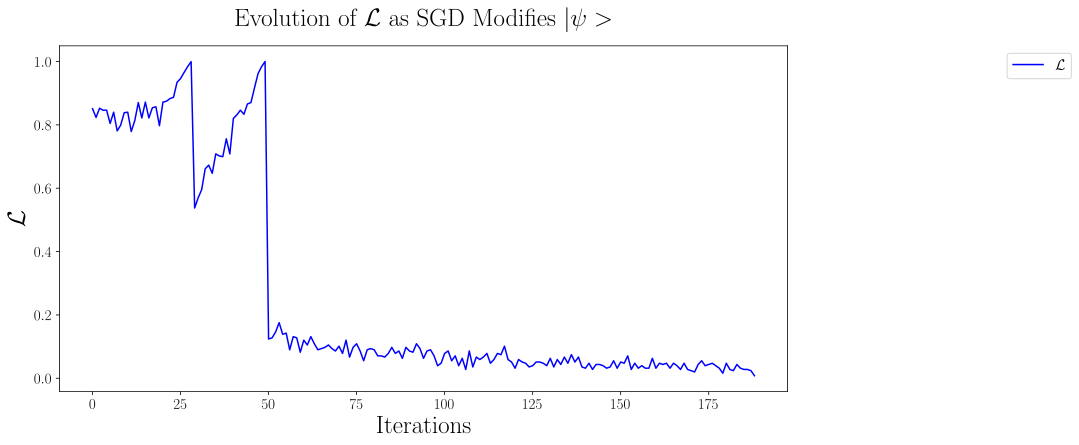

In [106]:
plt.figure(figsize=(16,7))

plt.plot(test_search[-2], label=r'$\mathcal{L}$', color='blue', linestyle='-')
#plt.plot(test_optimization[3], label=r'$Z_1\otimes Z_2$', color='dodgerblue', linestyle='-')

plt.legend(fontsize=15, bbox_to_anchor=(1.4,1))

plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{L}$',fontsize=25)

plt.title(r'Evolution of $\mathcal{L}$ as SGD Modifies $| \psi >$', fontsize=25)

plt.tight_layout()

plt.subplots_adjust(top=0.8)

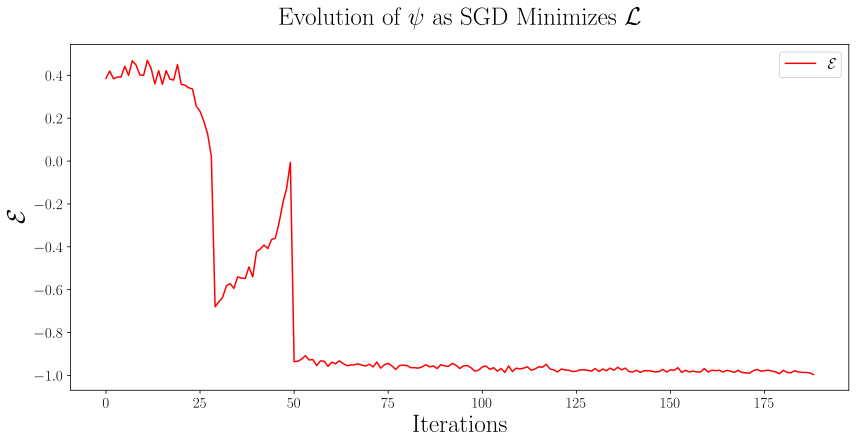

In [107]:
plt.figure(figsize=(12,7))

plt.plot(test_search[-1], label=r'$\mathcal{E}$', color='red', linestyle='-')
#plt.plot(test_optimization[3], label=r'$Z_1\otimes Z_2$', color='dodgerblue', linestyle='-')

plt.legend(fontsize=15, loc='best')

plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{E}$',fontsize=25)

plt.title(r'Evolution of $\psi$ as SGD Minimizes $\mathcal{L}$', fontsize=25)

plt.tight_layout()

plt.subplots_adjust(top=0.8)

In [0]:
emulator = Aer.get_backend('qasm_simulator')
shot_num = 1000
job = execute(test_ansatz_h2, emulator, shots=shot_num, memory=True)

In [57]:
hist = job.result().get_counts()
hist

{'00': 1, '01': 602, '10': 9, '11': 388}

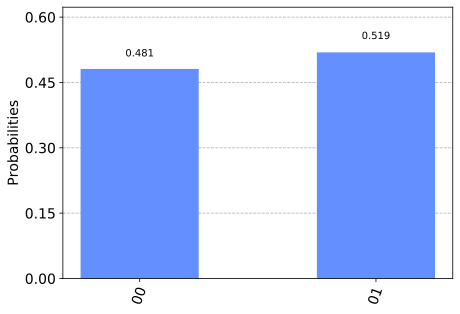

In [53]:
from qiskit.visualization import plot_histogram

plot_histogram( hist )

In [11]:
samples = job.result().get_memory()
print(samples)

['10', '00', '10', '00', '00', '10', '10', '00', '00', '01', '10', '00', '00', '10', '00', '10', '10', '00', '00', '00', '00', '10', '00', '00', '10', '10', '00', '00', '00', '10', '00', '10', '10', '10', '00', '10', '10', '00', '01', '00', '01', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '10', '00', '00', '00', '00', '00', '10', '10', '00', '00', '10', '00', '10', '00', '10', '10', '00', '00', '10', '10', '00', '10', '10', '10', '00', '01', '00', '10', '10', '00', '00', '00', '00', '10', '00', '00', '00', '10', '00', '00', '00', '00', '10', '00', '00', '00', '00', '00', '10', '00', '00', '00', '01', '00', '00', '00', '00', '10', '00', '00', '00', '10', '00', '00', '00', '10', '00', '00', '01', '00', '10', '00', '10', '00', '10', '00', '01', '00', '00', '00', '00', '00', '10', '00', '00', '00', '00', '00', '00', '00', '00', '10', '00', '10', '10', '01', '00', '10', '00', '10', '00', '00', '00', '00', '00', '00', '10', '00', '00', '00', '00', '00', '10', '10', '00', '10